# **Specific Test II. Lens Finding**

*  Imports Libraries:
 -  PyTorch (torch, torch.nn, torch.optim) for deep learning model building and optimization.
 -  torchvision.transforms for image transformations.
 -  torch.utils.data for dataset management and loading.
 -  WeightedRandomSampler to handle class imbalances in datasets.
 -  numpy for numerical operations.
 -  matplotlib.pyplot for visualizations (e.g., plotting graphs).
 -  os for file path and directory handling.
 -  roc_curve and auc from sklearn.metrics for evaluating model performance using ROC-AUC.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_curve, auc

*  Initialization: Loads image paths and assigns labels.
*  Length: Returns the number of images.
*  Fetching Item: Loads and transforms images, returns the image and its label.

In [2]:

# Custom dataset class
class LensingDataset(Dataset):
    def __init__(self, root_dir, label, transform=None):
        self.root_dir = root_dir
        self.label = label
        self.transform = transform
        self.images = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = np.load(img_path)  # Shape: (3, 64, 64)
        image = torch.tensor(image, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, self.label


**Normalization:** Transforms input images by normalizing with a mean of [0.5, 0.5, 0.5] and a standard deviation of [0.5, 0.5, 0.5].

In [3]:

# Define transformations
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

**Reload Datasets:** Loads the train_lenses, train_nonlenses, test_lenses, and test_nonlenses datasets using the LensingDataset class with appropriate labels (1 for lenses and 0 for non-lenses) and the defined transformation.

In [4]:

# Reload datasets with proper transform
train_lenses = LensingDataset("train_lenses", 1, transform=transform)
train_nonlenses = LensingDataset("train_nonlenses", 0, transform=transform)
test_lenses = LensingDataset("test_lenses", 1, transform=transform)
test_nonlenses = LensingDataset("test_nonlenses", 0, transform=transform)


**Create Imbalanced Dataset Handling:**

> *  Combines the train_lenses and train_nonlenses datasets into one using ConcatDataset.
*  Assigns labels (1 for lenses and 0 for non-lenses) to each image in the combined dataset.
*  Calculates class counts and class weights based on the inverse frequency of each class.
*  Computes sample weights for each image based on its label and the corresponding class weight.
*  Uses a WeightedRandomSampler to handle class imbalance by sampling images with replacement according to their sample weights.


In [5]:
# Create imbalanced dataset handling
train_dataset = torch.utils.data.ConcatDataset([train_lenses, train_nonlenses])
labels = [1] * len(train_lenses) + [0] * len(train_nonlenses)
class_counts = [len(train_nonlenses), len(train_lenses)]
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
sample_weights = [class_weights[label] for label in labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


**Create DataLoader for Training and Testing**

***train_loader:***
> * Loads the combined training dataset (train_dataset) using a DataLoader with a batch size of 32.
* The WeightedRandomSampler is used to ensure balanced sampling of classes based on sample weights.

***test_loader:***
> *  Loads the combined test dataset (test_dataset) using a DataLoader with a batch size of 32.
* The shuffle=False ensures that the test data is not shuffled.

In [6]:

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_dataset = torch.utils.data.ConcatDataset([test_lenses, test_nonlenses])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


**Convolutional Layers:**

*  First Conv2d (3 input channels, 32 output channels) with ReLU and MaxPool.
*  Second Conv2d (32 input channels, 64 output channels) with ReLU and MaxPool.

**Fully Connected Layers:** Flatten followed by two Linear layers (128 neurons, then 1 output with Sigmoid).

**Forward Pass:** Input passes through conv layers, then fully connected layers for classification.

In [7]:

# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

**Device Setup:** Selects GPU if available, else defaults to CPU.

**Model Initialization:** Creates an instance of the CNN model and moves it to the selected device.

**Loss Function:** Uses Binary Cross-Entropy loss (BCELoss).

**Optimizer:** Uses Adam optimizer with a learning rate of 0.001.

**Training Loop:**
*  Loops through specified epochs.
*  Loads batches from train_loader, moves data to the selected device.
*  Zeroes gradients, performs forward pass, calculates loss, and updates the model.
*  Prints average loss for each epoch.

In [8]:

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer)


Epoch 1, Loss: 0.2966
Epoch 2, Loss: 0.1783
Epoch 3, Loss: 0.1333
Epoch 4, Loss: 0.1005
Epoch 5, Loss: 0.0960


**Save Model weights**

In [9]:
import torch
import json

# Get the state dictionary (model weights)
state_dict = model.state_dict()

# Convert tensors to lists for JSON serialization
state_dict_json = {key: value.tolist() for key, value in state_dict.items()}

# Save to a JSON file
with open("model_weights_specific_task_2.json", "w") as json_file:
    json.dump(state_dict_json, json_file, indent=4)

**Evaluation Function:**
*  Switches the model to evaluation mode (model.eval()).
*  Collects true labels and predicted scores in y_true and y_scores.
*  Iterates through the test dataset (test_loader), performs inference, and stores results.
*  Calculates ROC Curve using roc_curve and computes AUC score using auc.
*  Plots the ROC curve and displays the AUC score in the plot legend.
*  Prints the AUC score in the console after evaluation.

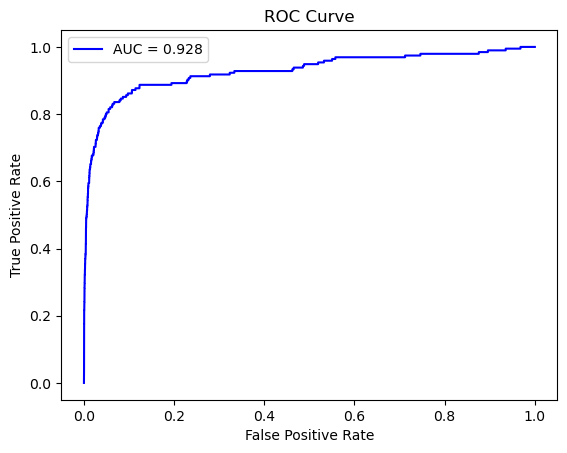

AUC Score: 0.928


In [10]:

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_scores = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.numpy()
            outputs = model(images).squeeze().cpu().numpy()
            y_true.extend(labels)
            y_scores.extend(outputs)

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.3f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    print(f"AUC Score: {auc_score:.3f}")

evaluate_model(model, test_loader)
